In [1]:
import itertools
import functools

import math

import numpy as np
import pandas as pd

import pyreadr

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

import json
import requests
import pprint
from io import StringIO
from typing import List, Dict, Any, Tuple

from scipy.sparse import coo_matrix

import networkx as nx

In [2]:
prot_matr_fc = pyreadr.read_r('../data/training/proteins.matrix.sva.0.5.1.FC.RData')['proteins.matrix.sva.0.5.1.FC']
gene_annotation = pyreadr.read_r('../data/training/gene.annotations._load_.RData')['gene.annotations']
go = pyreadr.read_r('../data/training/GO.raw._load_.RData')['GO.raw']

In [3]:
def get_context(gene_id: str) -> requests.Response:
    output_format = "tsv-no-header"
    specie_id = 4932

    url = f"https://string-db.org/api/{output_format}/network?identifiers={gene_id}"
    params = {
        "identifiers": gene_id,
        "species": specie_id
    }

    return requests.post(url, params)

def get_functional_annotation(gene_id: str) -> requests.Response:
    output_format = "json"
    specie_id = 4932

    url = f"https://string-db.org/api/{output_format}/functional_annotation?identifiers={gene_id}"
    params = {
        "identifiers": gene_id,
        "species": specie_id
    }

    return requests.post(url, params)

def transform_response(json_response: requests.Response) -> Dict[str, Any]:
    return {
        "gene_prefered_name": json_response[0]['preferredNames'],
        "go_terms": [resp['term'] for resp in json_response],
        "categories": [resp['category'] for resp in json_response],
        "description": [resp['description'] for resp in json_response]
    }

def update_gene_annotation(genes: List[str], previous_gene_annotation: Dict[str, Any]):
    global gene_annotation
    _gene_annotation = previous_gene_annotation.copy()

    try:
        print(f'testing if {len(genes)} genes are already in the _gene_annotation')
        for gene in genes:
            if gene not in _gene_annotation:
                resp = get_functional_annotation(gene)
                if (json_response := resp.json()) and resp.status_code == 200 and len(json_response) > 0:
                    _gene_annotation[gene] = transform_response(json_response)
    except BaseException as err:
        print("Connection was closed so we store the current genes that we got")
        print(f"Unexpected {err=}, {type(err)=}")
    finally: 
        print('updating the list of gene annotations')
        print(f'adding {len(_gene_annotation) - len(gene_annotation)} new genes')
        with open("./data/gene_annotation.json", "w") as fp:
            fp.write(json.dumps(_gene_annotation))

        gene_annotation = _gene_annotation.copy()

def to_dataframe(x):
    tsv_string = StringIO(x)
    df = pd.read_csv(tsv_string, sep="\t", names=[
        'stringId_A', 'stringId_B', 'preferredName_A', 'preferredName_B', 
        'ncbiTaxonId', 'score', 'nscore', 'fscore', 'pscore', 'ascore',
        'escore', 'dscore', 'tscore'
    ])
    df = df.drop_duplicates(subset=['preferredName_A', 'preferredName_B'], keep='last')

    df['stringId_A'] = df['stringId_A'].map(lambda x: x.strip('4932.'))
    df['stringId_B'] = df['stringId_B'].map(lambda x: x.strip('4932.'))

    return df[['stringId_A', 'stringId_B', 'score']]

def to_adj_matrix(x: pd.DataFrame) -> np.matrix:
    def get_idx(name: str) -> np.array:
        return [np.where(unique_labels == elem)[0][0] for _, elem in x[name].iteritems()]

    name_a, name_b = 'stringId_A', 'stringId_B'
    unique_labels = np.unique(pd.concat([x[name_a], x[name_b]]))
    graph_size = len(unique_labels)

    return coo_matrix((x['score'].values, (get_idx(name_a), get_idx(name_b))), shape=(graph_size, graph_size))

def get_node_labels(x: pd.DataFrame) -> np.array:
    name_a, name_b = 'stringId_A', 'stringId_B'
    return np.unique(pd.concat([x[name_a], x[name_b]]))


In [ ]:
gene_context = [get_context(gene_id) for gene_id in prot_matr_fc['ORF'].unique()]
gene_functional_annotation = [get_functional_annotation(gene_id) for gene_id in prot_matr_fc['ORF'].unique()]

tsv_records = [ 
    {
        "gene_id": gene_id,
        "interaction_network": text 
    }
    for gene_id, response in zip(prot_matr_fc['ORF'].unique(), gene_context)
    if 'Error' not in (text := response.text)
]

functional_records = {
    gene_id: transform_response(json_response)
    for gene_id, response in zip(prot_matr_fc['ORF'].unique(), gene_functional_annotation)
    if (json_response := response.json()) and len(json_response) > 0 and response.status_code == 200
}

with open("../data/training/tsv_records.json", "w") as fp:
    fp.write(json.dumps(tsv_records))

with open("../data/training/gene_annotation.json", "w") as fp:
    fp.write(json.dumps(functional_records))

In [4]:
df = pd.read_json('../data/training/tsv_records.json')
df

,gene_id,interaction_network
0,YAL003W,4932.YAL003W\t4932.YBL027W\tEFB1\tRPL19B\t4932...
1,YAL005C,4932.YAL005C\t4932.YBR101C\tSSA1\tFES1\t4932\t...
2,YAL007C,4932.YAL007C\t4932.YBR210W\tERP2\tERV15\t4932\...
3,YAL012W,4932.YAL012W\t4932.YLL058W\tCYS3\tYLL058W\t493...
4,YAL035W,4932.YAL035W\t4932.YJR123W\tFUN12\tRPS5\t4932\...
...,...,...
721,YPR165W,4932.YBL105C\t4932.YER008C\tPKC1\tSEC3\t4932\t...
722,YPR181C,4932.YDL195W\t4932.YFL038C\tSEC31\tYPT1\t4932\...
723,YPR183W,4932.YBL082C\t4932.YGR036C\tALG3\tCAX4\t4932\t...
724,YPR187W,4932.YBR154C\t4932.YPR187W\tRPB5\tRPO26\t4932\...


In [11]:
df = pd.read_json('./data/tsv_records.json')
df['interaction_network'] = df['interaction_network'].apply(to_dataframe)
df['adj_matrix'] = df['interaction_network'].apply(to_adj_matrix)
df['node_labels'] = df['interaction_network'].apply(get_node_labels)

with open('./data/gene_annotation.json', 'r') as fp:
    gene_annotation = json.load(fp)

# map stores the gene_id used by the study with its prefered name
# this allows us to look up node labels (essential or not essential)
gene_map = { 
    gene_annotation[key]['gene_prefered_name'][0]: key
    for key in prot_matr_fc['ORF'].unique()[:10]
    if key in gene_annotation
}

In [35]:
df['node_labels_dataset'] = df['node_labels'].map(lambda x: [y for y in x if y in prot_matr_fc['ORF'].unique()])
df['size'] = df['node_labels_dataset'].map(len)

In [53]:
df[df['size'] >= 6]

,gene_id,interaction_network,adj_matrix,node_labels,node_labels_dataset,size
0,YAL003W,stringId_A stringId_B score 1 YAL003...,"(0, 1)\t0.998\n (0, 6)\t0.999\n (0, 10)\t0...","[YAL003W, YBL027W, YBR118W, YBR189W, YGL103W, ...","[YAL003W, YGL103W, YKL056C, YKL081W, YLR075W, ...",7
1,YAL005C,stringId_A stringId_B score 1 YAL005...,"(0, 1)\t0.992\n (0, 2)\t0.997\n (0, 4)\t0....","[YAL005C, YBR101C, YDR172W, YGL073W, YLL024C, ...","[YAL005C, YLL024C, YLL026W, YMR186W, YNL007C, ...",8
3,YAL012W,stringId_A stringId_B score 1 YAL012W ...,"(0, 7)\t0.942\n (0, 9)\t0.946\n (0, 6)\t0....","[YAL012W, YER043C, YER091C, YGR012W, YGR155W, ...","[YAL012W, YER043C, YER091C, YGR155W, YLR027C, ...",7
4,YAL035W,stringId_A stringId_B score 1 YAL035W ...,"(0, 5)\t0.999\n (0, 3)\t0.999\n (0, 7)\t0....","[YAL035W, YBR079C, YDR496C, YGL103W, YHL015W, ...","[YAL035W, YBR079C, YGL103W, YHL015W, YJR123W, ...",10
5,YAL038W,stringId_A stringId_B score 1 YAL038...,"(0, 7)\t0.995\n (0, 4)\t0.997\n (0, 2)\t0....","[YAL038W, YBR196C, YBR218C, YCR012W, YDR050C, ...","[YAL038W, YBR196C, YBR218C, YCR012W, YDR050C, ...",10
...,...,...,...,...,...,...
712,YPR074C,stringId_A stringId_B score 1 YBR117...,"(0, 4)\t0.947\n (0, 8)\t0.954\n (0, 6)\t0....","[YBR117C, YBR196C, YDR050C, YGR043C, YHR183W, ...","[YBR196C, YDR050C, YHR183W, YKL060C, YLR354C, ...",8
713,YPR103W,stringId_A stringId_B score 1 YBL041...,"(0, 9)\t0.999\n (0, 10)\t0.999\n (0, 3)\t0...","[YBL041W, YDL007W, YDL097C, YDL147W, YDR394W, ...","[YBL041W, YDL007W, YDL097C, YDR427W, YER012W, ...",8
718,YPR145W,stringId_A stringId_B score 1 YBL039C ...,"(0, 8)\t0.51\n (0, 7)\t0.783\n (0, 9)\t0.8...","[YBL039C, YER052C, YGR124W, YJL130C, YKL106W, ...","[YBL039C, YER052C, YGR124W, YJL130C, YLR027C, ...",10
720,YPR163C,stringId_A stringId_B score 1 YAL035...,"(0, 9)\t0.606\n (0, 3)\t0.78\n (0, 4)\t0.8...","[YAL035W, YBR079C, YDR429C, YER165W, YGL049C, ...","[YAL035W, YBR079C, YDR429C, YER165W, YOL139C, ...",6


(array([726., 688., 623., 509., 436., 368., 280., 198., 138.,  78.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

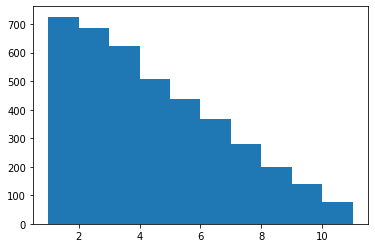

In [51]:
plt.hist(df['size'], cumulative=-1)

<AxesSubplot:xlabel='size', ylabel='Count'>

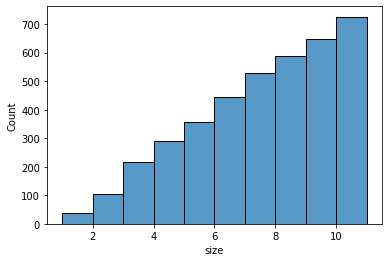

In [50]:
sns.histplot(data = df, x='size', stat='count', cumulative=-1, bins=10)
# sns.ecdfplot(data = df, stat='count')
GZ61165216
